## Model definition

In [1]:
using MomentClosure, Catalyst

┌ Info: Precompiling MomentClosure [01a1b25a-ecf0-48c5-ae58-55bfd5393600]
└ @ Base loading.jl:1278


In [2]:
# using Catalyst

#= Notes:
  -`\rightarrow` indicates mass-action reactions 
    for which the propensity functions are constructed accordingly
    to the law of mass action. 
  - the system-size parameter Ω must be included manually
=#

rn = @reaction_network begin
  (c₁/Ω^2), 2X + Y → 3X
  (c₂), X → Y
  (c₃*Ω, c₄), 0 ↔ X
end c₁ c₂ c₃ c₄ Ω

Model ##ReactionSystem#253 with 4 equations
States (2):
  X(t)
  Y(t)
Parameters (5):
  c₁
  c₂
  c₃
  c₄
  Ω

In [3]:
# net stoichiometry matrix
get_S_mat(rn)

2×4 Array{Int64,2}:
  1  -1  1  -1
 -1   1  0   0

In [4]:
# vector of propensity functions
propensities(rn, combinatoric_ratelaw=false)

4-element Array{SymbolicUtils.Mul{Real,Int64,Dict{Any,Number},Nothing},1}:
 c₁*X(t)*Y(t)*(Ω^-2)*(X(t) - 1)
 c₂*X(t)
 c₃*Ω
 c₄*X(t)

In [5]:
# using MomentClosure's ReactionSystemMod

@parameters t, c₁, c₂, c₃, c₄, Ω
@variables X(t), Y(t)

# stoichiometric matrix
S_mat = [ 1 -1  1 -1;
         -1  1  0  0]

# propensity functions
a = [c₁*X*Y*(X-1)/Ω^2, c₂*X, c₃*Ω, c₄*X]

rn2 = ReactionSystemMod(t, [X, Y], [c₁, c₂, c₃, c₄, Ω], a, S_mat)

ReactionSystemMod(t, Term{Real,Nothing}[X(t), Y(t)], Sym{ModelingToolkit.Parameter{Real},Nothing}[c₁, c₂, c₃, c₄, Ω], SymbolicUtils.Mul{Real,Int64,Dict{Any,Number},Nothing}[c₁*X(t)*Y(t)*(Ω^-2)*(X(t) - 1), c₂*X(t), c₃*Ω, c₄*X(t)], [1 -1 1 -1; -1 1 0 0])

## Generating moment equations

In [6]:
# raw moment equations
raw_eqs = generate_raw_moment_eqs(rn, 2, combinatoric_ratelaw=false)

MomentClosure.RawMomentEquations(Model ##ODESystem#295 with 5 equations
States (9):
  μ₁₀(t)
  μ₀₁(t)
  μ₂₀(t)
  μ₁₁(t)
  μ₀₂(t)
  μ₂₁(t)
⋮
Parameters (5):
  c₁
  c₂
  c₃
  c₄
  Ω, Dict{Any,Any}((0, 0) => 1,(3, 0) => μ₃₀(t),(2, 2) => μ₂₂(t),(2, 1) => μ₂₁(t),(1, 0) => μ₁₀(t),(3, 1) => μ₃₁(t),(2, 0) => μ₂₀(t),(0, 1) => μ₀₁(t),(1, 3) => μ₁₃(t),(4, 0) => μ₄₀(t)…), 2, 2, 4, [(0, 0), (1, 0), (0, 1), (2, 0), (1, 1), (0, 2), (3, 0), (2, 1), (1, 2), (0, 3), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4)], [(2, 0), (1, 1), (0, 2)], [(3, 0), (2, 1), (1, 2), (0, 3), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4)], [(1, 0), (0, 1)])

In [7]:
using Latexify
latexify(raw_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_3} \Omega + c{_1} \mu{_{21}} \Omega^{-2} - c{_2} \mu{_{10}} - c{_4} \mu{_{10}} - c{_1} \mu{_{11}} \Omega^{-2} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} \mu{_{10}} + c{_1} \mu{_{11}} \Omega^{-2} - c{_1} \mu{_{21}} \Omega^{-2} \\
\frac{d\mu{_{20}}}{dt} =& c{_2} \mu{_{10}} + c{_3} \Omega + c{_4} \mu{_{10}} + 2 c{_1} \mu{_{31}} \Omega^{-2} + 2 c{_3} \Omega \mu{_{10}} - 2 c{_2} \mu{_{20}} - 2 c{_4} \mu{_{20}} - c{_1} \mu{_{11}} \Omega^{-2} - c{_1} \mu{_{21}} \Omega^{-2} \\
\frac{d\mu{_{11}}}{dt} =& c{_2} \mu{_{20}} + c{_1} \mu{_{11}} \Omega^{-2} + c{_1} \mu{_{22}} \Omega^{-2} + c{_3} \Omega \mu{_{01}} - c{_2} \mu{_{10}} - c{_2} \mu{_{11}} - c{_4} \mu{_{11}} - c{_1} \mu{_{12}} \Omega^{-2} - c{_1} \mu{_{31}} \Omega^{-2} \\
\frac{d\mu{_{02}}}{dt} =& c{_2} \mu{_{10}} + c{_1} \mu{_{21}} \Omega^{-2} + 2 c{_2} \mu{_{11}} + 2 c{_1} \mu{_{12}} \Omega^{-2} - c{_1} \mu{_{11}} \Omega^{-2} - 2 c{_1} \mu{_{22}} \Omega^{-2}
\end{align*}
"

In [8]:
# central moment equations
central_eqs = generate_central_moment_eqs(rn, 2, combinatoric_ratelaw=false)
latexify(central_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_3} \Omega + c{_1} M{_{21}} \Omega^{-2} + c{_1} M{_{20}} \mu{_{01}} \Omega^{-2} + c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} + 2 c{_1} M{_{11}} \mu{_{10}} \Omega^{-2} - c{_2} \mu{_{10}} - c{_4} \mu{_{10}} - c{_1} M{_{11}} \Omega^{-2} - c{_1} \mu{_{01}} \mu{_{10}} \Omega^{-2} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} \mu{_{10}} + c{_1} M{_{11}} \Omega^{-2} + c{_1} \mu{_{01}} \mu{_{10}} \Omega^{-2} - c{_1} M{_{21}} \Omega^{-2} - 2 c{_1} M{_{11}} \mu{_{10}} \Omega^{-2} - c{_1} M{_{20}} \mu{_{01}} \Omega^{-2} - c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} \\
\frac{dM{_{20}}}{dt} =& c{_2} \mu{_{10}} + c{_3} \Omega + c{_4} \mu{_{10}} + 2 c{_1} M{_{31}} \Omega^{-2} + c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} + 2 c{_1} M{_{11}} \Omega^{-2} \mu{_{10}}^{2} + 4 c{_1} M{_{21}} \mu{_{10}} \Omega^{-2} + 2 c{_1} M{_{30}} \mu{_{01}} \Omega^{-2} + 4 c{_1} M{_{20}} \mu{_{01}} \mu{_{10}} \Omega^{-2} - 2 c{_2} M{_{20}} - 2 c{_4} M{_{20}} - c{_1} M{_{11}} \Omega^{-2}

## Performing moment closure

In [9]:
# normal closure on raw moment equations
closed_raw_eqs = moment_closure(raw_eqs, "normal")
latexify(closed_raw_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_3} \Omega + c{_1} \mu{_{01}} \mu{_{20}} \Omega^{-2} + 2 c{_1} \mu{_{10}} \mu{_{11}} \Omega^{-2} - c{_2} \mu{_{10}} - c{_4} \mu{_{10}} - c{_1} \mu{_{11}} \Omega^{-2} - 2 c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} \mu{_{10}} + c{_1} \mu{_{11}} \Omega^{-2} + 2 c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} - c{_1} \mu{_{01}} \mu{_{20}} \Omega^{-2} - 2 c{_1} \mu{_{10}} \mu{_{11}} \Omega^{-2} \\
\frac{d\mu{_{20}}}{dt} =& c{_2} \mu{_{10}} + c{_3} \Omega + c{_4} \mu{_{10}} + 2 c{_3} \Omega \mu{_{10}} + 2 c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} + 6 c{_1} \mu{_{11}} \mu{_{20}} \Omega^{-2} - 2 c{_2} \mu{_{20}} - 2 c{_4} \mu{_{20}} - c{_1} \mu{_{11}} \Omega^{-2} - c{_1} \mu{_{01}} \mu{_{20}} \Omega^{-2} - 4 c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{3} - 2 c{_1} \mu{_{10}} \mu{_{11}} \Omega^{-2} \\
\frac{d\mu{_{11}}}{dt} =& c{_2} \mu{_{20}} + c{_1} \mu{_{11}} \Omega^{-2} + c{_3} \Omega \mu{_{01}} + c{_1} \mu{_{02}} \

In [10]:
# higher order moment closure functions
latexify(closed_raw_eqs, :closure)

L"\begin{align*}
\mu{_{30}} =& 3 \mu{_{10}} \mu{_{20}} - 2 \mu{_{10}}^{3} \\
\mu{_{21}} =& \mu{_{01}} \mu{_{20}} + 2 \mu{_{10}} \mu{_{11}} - 2 \mu{_{01}} \mu{_{10}}^{2} \\
\mu{_{12}} =& \mu{_{02}} \mu{_{10}} + 2 \mu{_{01}} \mu{_{11}} - 2 \mu{_{10}} \mu{_{01}}^{2} \\
\mu{_{03}} =& 3 \mu{_{01}} \mu{_{02}} - 2 \mu{_{01}}^{3} \\
\mu{_{40}} =& 6 \mu{_{10}}^{4} + 3 \mu{_{20}}^{2} + 4 \mu{_{10}} \mu{_{30}} - 12 \mu{_{20}} \mu{_{10}}^{2} \\
\mu{_{31}} =& \mu{_{01}} \mu{_{30}} + 6 \mu{_{01}} \mu{_{10}}^{3} + 3 \mu{_{10}} \mu{_{21}} + 3 \mu{_{11}} \mu{_{20}} - 6 \mu{_{11}} \mu{_{10}}^{2} - 6 \mu{_{01}} \mu{_{10}} \mu{_{20}} \\
\mu{_{22}} =& \mu{_{02}} \mu{_{20}} + 2 \mu{_{11}}^{2} + 2 \mu{_{01}} \mu{_{21}} + 2 \mu{_{10}} \mu{_{12}} + 6 \mu{_{01}}^{2} \mu{_{10}}^{2} - 2 \mu{_{02}} \mu{_{10}}^{2} - 2 \mu{_{20}} \mu{_{01}}^{2} - 8 \mu{_{01}} \mu{_{10}} \mu{_{11}} \\
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} + 3 \mu{_{01}} \mu{_{12}} + 3 \mu{_{02}} \mu{_{11}} + 6 \mu{_{10}} \mu{_{01}}^{3} - 6 \mu{_{11}} \

In [11]:
# normal closure on central moment equations
closed_central_eqs = moment_closure(central_eqs, "normal")
latexify(closed_central_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_3} \Omega + c{_1} M{_{20}} \mu{_{01}} \Omega^{-2} + c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} + 2 c{_1} M{_{11}} \mu{_{10}} \Omega^{-2} - c{_2} \mu{_{10}} - c{_4} \mu{_{10}} - c{_1} M{_{11}} \Omega^{-2} - c{_1} \mu{_{01}} \mu{_{10}} \Omega^{-2} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} \mu{_{10}} + c{_1} M{_{11}} \Omega^{-2} + c{_1} \mu{_{01}} \mu{_{10}} \Omega^{-2} - 2 c{_1} M{_{11}} \mu{_{10}} \Omega^{-2} - c{_1} M{_{20}} \mu{_{01}} \Omega^{-2} - c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} \\
\frac{dM{_{20}}}{dt} =& c{_2} \mu{_{10}} + c{_3} \Omega + c{_4} \mu{_{10}} + c{_1} \mu{_{01}} \Omega^{-2} \mu{_{10}}^{2} + 6 c{_1} M{_{11}} M{_{20}} \Omega^{-2} + 2 c{_1} M{_{11}} \Omega^{-2} \mu{_{10}}^{2} + 4 c{_1} M{_{20}} \mu{_{01}} \mu{_{10}} \Omega^{-2} - 2 c{_2} M{_{20}} - 2 c{_4} M{_{20}} - c{_1} M{_{11}} \Omega^{-2} - c{_1} M{_{20}} \mu{_{01}} \Omega^{-2} - c{_1} \mu{_{01}} \mu{_{10}} \Omega^{-2} \\
\frac{dM{_{11}}}{dt} =& c{_2} M{_{20}} + c{_1} 

In [12]:
latexify(closed_central_eqs, :closure)

L"\begin{align*}
M{_{30}} =& 0 \\
M{_{21}} =& 0 \\
M{_{12}} =& 0 \\
M{_{03}} =& 0 \\
M{_{40}} =& 3 M{_{20}}^{2} \\
M{_{31}} =& 3 M{_{11}} M{_{20}} \\
M{_{22}} =& M{_{02}} M{_{20}} + 2 M{_{11}}^{2} \\
M{_{13}} =& 3 M{_{02}} M{_{11}} \\
M{_{04}} =& 3 M{_{02}}^{2}
\end{align*}
"

## Solving the moment equations

In [13]:
# check the ordering of parameters in the model
paramsmap(rn)

Dict{Sym{ModelingToolkit.Parameter{Real},Nothing},Int64} with 5 entries:
  Ω  => 5
  c₁ => 1
  c₃ => 3
  c₄ => 4
  c₂ => 2

In [14]:
# check the ordering of species in the model
speciesmap(rn)

Dict{Term{Real,Nothing},Int64} with 2 entries:
  Y(t) => 2
  X(t) => 1

In [15]:
# parameter values [c₁, c₂, c₃, c₄, Ω]
p = [0.9, 2, 1, 1, 100]

# initial molecule numbers of species [X, Y]
u₀ = [1, 1]

# deterministic initial conditions
u₀map = deterministic_IC(u₀, closed_raw_eqs) 

# time interval to solve one on
tspan = (0., 100.)

# convert the closed raw moment equations into a DifferentialEquations ODEProblem
oprob = ODEProblem(closed_raw_eqs, u₀map, tspan, p)

using OrdinaryDiffEq
# solve using Tsit5() solver
@time sol = solve(oprob, Tsit5(), saveat=0.1);

 21.084328 seconds (23.95 M allocations: 1.264 GiB, 23.92% gc time)


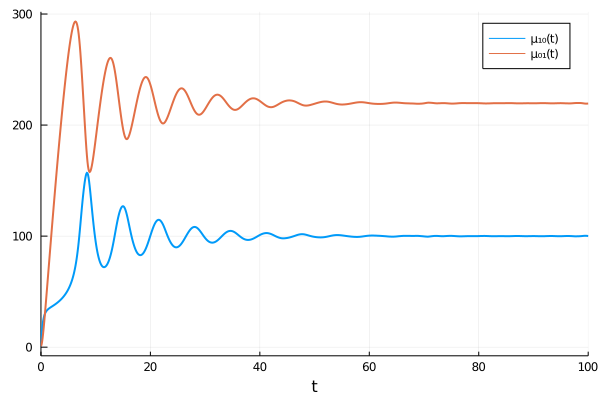

In [16]:
using Plots
plot(sol, vars=(0, [1,2]), lw=2)

In [17]:
# Run SSA
using DiffEqJump

# convert ReactionSystem into JumpSystem
# Note: can directly convert the ReactionSystem to DiscreteProblem 
# but then combinatoric_ratelaws cannot be set
jsys = convert(JumpSystem, rn, combinatoric_ratelaws=false)

# create a DiscreteProblem encoding that the molecule numbers are integer-valued
dprob = DiscreteProblem(jsys, u₀, tspan, p) # same parameters as defined earlier

# create a JumpProblem: specify Gillespie's Direct Method as the solver
# and SET save_positions to (false, false) as otherwise time of each
# reaction occurence would be saved (complicating moment estimates)
jprob = JumpProblem(jsys, dprob, Direct(), save_positions=(false, false))

# define an EnsembleProblem to simulate multiple trajectories
ensembleprob  = EnsembleProblem(jprob)

# simulate 10000 SSA trajectories
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.1, trajectories=10000);

111.087760 seconds (11.62 M allocations: 1.132 GiB, 1.99% gc time)


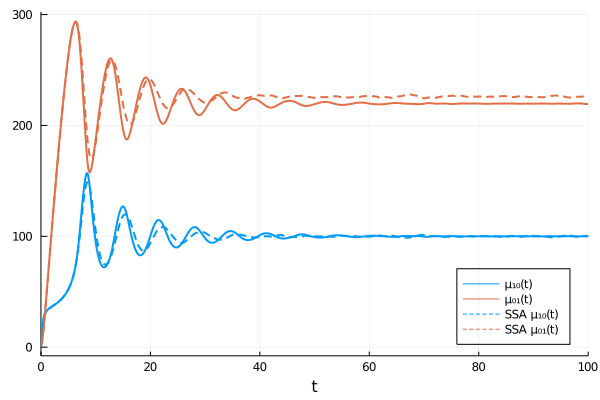

In [18]:
using DiffEqBase.EnsembleAnalysis

means_SSA = timeseries_steps_mean(sol_SSA)
plot!(means_SSA, lw=2, labels=["SSA μ₁₀(t)" "SSA μ₀₁(t)"], linestyle=:dash, 
      linecolor=[1 2], background_color_legend=nothing, legend=:bottomright)